c:\Users\MSI-GF63Thin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\MSI-GF63Thin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5332 - loss: 7.4224
Epoch 1: val_loss improved from inf to 36.07531, saving model to cnn_floor_type_classifier_optimized_with_augmentation222.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 173s 533ms/step - accuracy: 0.5337 - loss: 7.4157 - val_accuracy: 0.1250 - val_loss: 36.0753
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8277 - loss: 3.1075
Epoch 2: val_loss improved from 36.07531 to 19.28380, saving model to cnn_floor_type_classifier_optimized_with_augmentation222.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 497ms/step - accuracy: 0.8277 - loss: 3.1060 - val_accuracy: 0.2225 - val_loss: 19.2838
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8462 - loss: 2.0127
Epoch 3: val_loss improved from 19.28380 to 2.52303, saving model to cnn_floor_type_classifier_optimized_with_augmentation222.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 524ms/step - accuracy: 0.8463 - loss: 2.0123 - val_accuracy: 0.6550 - val_lo

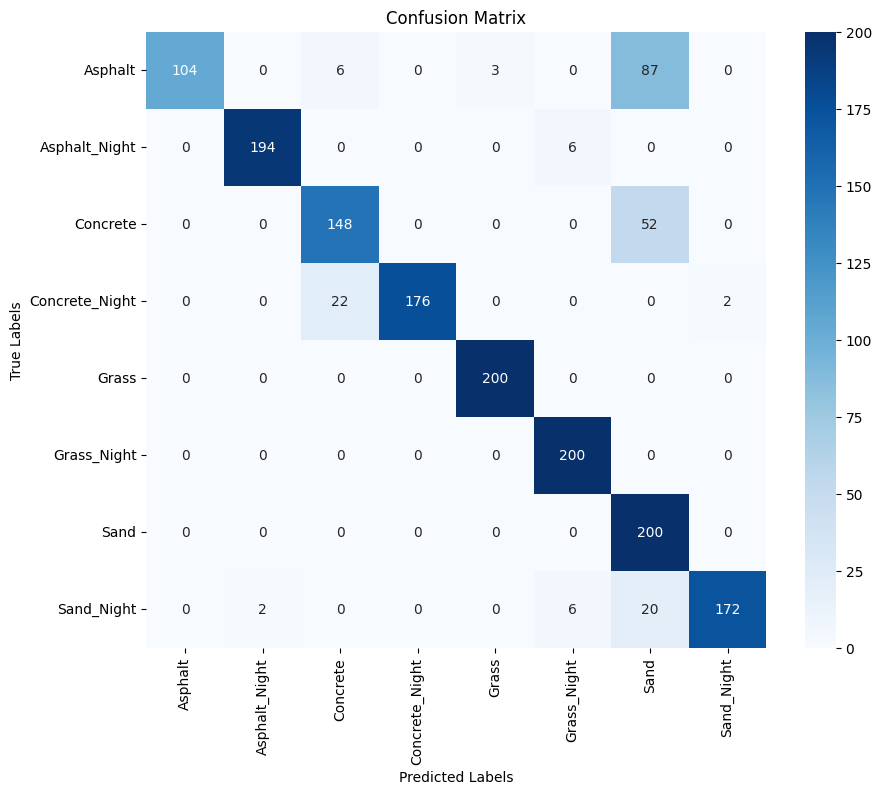

In [4]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        label = subfolder
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img = cv2.imread(os.path.join(subfolder_path, filename))
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize to uniform 64x64 pixels
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Set directory paths
train_dir = "E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\ImageDataset\\Train"
test_dir = "E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\ImageDataset\\Test"

# Load images and labels
train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Normalize images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Encode labels to one-hot vectors
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

joblib.dump(label_binarizer, 'label_binarizer.joblib')

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# Build the CNN model 
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(label_binarizer.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
checkpoint = ModelCheckpoint('cnn_floor_type_classifier_optimized_with_augmentation222.keras', monitor='val_loss', save_best_only=True, verbose=1)
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32), 
                    epochs=10, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[checkpoint])

# Load the best model
model.load_weights('cnn_floor_type_classifier_optimized_with_augmentation222.keras')

# Predict probabilities and evaluate
prob_predictions = model.predict(test_images)
label_predictions = np.argmax(prob_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Output class probabilities
class_probabilities = pd.DataFrame(prob_predictions, columns=label_binarizer.classes_)
print("Class Probabilities:")
print(class_probabilities)

# Evaluate model
print("Classification Report:")
print(classification_report(true_labels, label_predictions, target_names=label_binarizer.classes_))
print("Accuracy:", accuracy_score(true_labels, label_predictions))
logloss = log_loss(test_labels, prob_predictions)
print("Log Loss:", logloss)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, label_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
